# Reinforcement Learning pour le Yams

## Objectifs

Développer un environnement de jeu pour le Yams et entraîner un algorithme de renforcement pour jouer au Yams.

In [14]:
import numpy as np

## Réprésentation des figures

Chaque type de figure (Nombre, Pair/Brelan/Carré/Yams,...) est représenté par une classe qui permet de définir si avec une combinaison de dès (représentation par histogramme), il est possible de réaliser la figure et le nombre de point qu'elle rapporte le cas échéant.

In [15]:
class Number():
    def __init__(self, number:int):
        self.number = number

    def is_valid(self, dices:np.array):
        return dices[self.number] > 0

    def compute_value(self, dices:np.array):
        return (self.number + 1) * dices[self.number]

# Number(2) compte le nombre de 3 parmis les dès
print(Number(2).compute_value(np.array([0, 3, 2, 0, 0, 0])))

6


## Environnement de tour

L'environnement de tour est identique à l'environnement donné. Le vecteur de récompense est déterminé en prenant la figure disponible qui rapporte le plus de point pour chaque combinaison de dés.

## Politique du Tour

Plusieurs choix de politique du tour sont possibles. Pour des raisons de performances, on utilise une politique `greedy`, c'est-à-dire la value function dépend de la reward maximal associé à chaque état terminal. Grâce à cet politique, il est possible de directement calculer la `value function` $V$ de l'état terminal d'un tour à partir de l'état $s$ de l'environnement de Yams car celle-ci est indépendante de la politique du jeu de Yams.


$$V_\pi(s_{dice}) = max_{s,a}(r_{(s, a)})$$ 
où $r_(s, a)$ est la reward associé à la décision d'effectuer l'action $a$ dans l'état $s$ au sein de l'environnnement du Yams.

A partir de cet reward on peut calculer la policy en utilisant les equations de Bellman.

$$\pi(s) = argmax_a \sum_{s',r} p(s',r|s,a)[r + \gamma V\pi(s')]$$

Ce choix de politique est justifié par un besoin de performances et la possibilité de précalculé la politique pour chaque état $s$ du jeu de Yams.


In [16]:
# Partie du code récupérant le vecteur de récompense
from turn_env import TurnEnvironment

def compute_v3():
    figures = [Number(0), Number(1), Number(2)]
    MyTurn = TurnEnvironment(3, 3)
    reward_table = np.zeros((len(MyTurn.S),len(figures)))
    for i, s in enumerate(MyTurn.S):
        Aa = get_actions(s)
        for a, r in Aa :
            reward_table[i,a]= r 
    v_3 = reward_table.max(axis=1) 

## Environnement de partie

Les états sont représenté par un vecteur binaire indiquant si la figure a été prise ou non durant la partie.

Si l'on considère les règles de Yams suivantes:

    - 3 dès à 3 faces
    - Figures: Somme des dès à 1, 2 et 3 faces et le Brelan

$(0,0,0,0)$ est `l'état initial`

$(1, 1, 1,1)$ est `l'état terminal`

Une action $a$ est représenté par un entier $i$ qui correspond à l'ensemble des indices des cases non cochés dans l'état courant $s$

La récompense associé à $(s, a)$ dépend du lancer de dès obtenue dans l'environnement de tour.

Le nombre d'états est $|S| = 2^{nb\_figures}$

In [17]:
import itertools
import itertools
from random import choice

import numpy as np
from tqdm import tqdm

from figures import Figure
from turn_env import TurnEnvironment


def default_RL_policy(state, actions):
    """Default policy, greedy"""
    return max(actions, key=lambda x: x[1])

def random_policy(state, actions):
    '''random policy'''
    return choice(actions)

class YamsEnv:
    """Class to represent a Yams Game.
    score_sheet: ndarray of size (nb_dice, coombinaison)"""

    def __init__(self, nb_dice: int, nb_face: int, figures: dict[Figure], RL_policy: callable = default_RL_policy, saved_turnQs=None):
        self.nb_face = nb_face
        self.nb_dice = nb_dice
        self.MyTurn = TurnEnvironment(self.nb_dice,self.nb_face)
        self.figures = figures
        self.states = self.get_states()
        if saved_turnQs is not None:
            self.turnQs = np.load(saved_turnQs,allow_pickle=True).item()
        else:
            self.turnQs = self.get_turnQs() # List of all possible TurnEnv Q value for each YamsEnv state
        self.RL_policy = RL_policy
        self.scored = [False for _ in range(len(figures))]
        self.tot_reward = 0

    def get_states(self):
        """Return a list of all possibles states"""
        states = []
        for it in itertools.product(range(2), repeat=len(self.figures)):
            states.append(tuple(it))
        return states
    
    def get_turnQs(self):
        '''Return a list of all possible TurnEnv Q value for each YamsEnv state'''
        turnQs = {}
        for scored in tqdm(self.states):
            self.scored = scored
            reward_table = np.zeros((len(self.MyTurn.S),len(self.figures)))
            for i, s in enumerate(self.MyTurn.S):
                Aa = self.get_actions(s)
                for a, r in Aa :
                    reward_table[i,a]= r

            v_3 = reward_table.max(axis=1)
            v_2,Q_2 = self.MyTurn.One_step_backward(v_3)
            v_1,Q_1 = self.MyTurn.One_step_backward(v_2)
            turnQs[scored] = (Q_1, Q_2)
        return turnQs
    
    def get_actions(self, dices):
        """Return a list of all possible actions from state s."""
        actions = []
        for i, figure in enumerate(self.figures):
            if figure.is_valid(dices) and not self.scored[i]:
                future_reward = figure.compute_value(dices)
                actions.append((i, future_reward))
        if not actions: # Empty list
            for i in range(len(self.figures)):
                if not self.scored[i]:
                    actions.append((i, 0))
        return actions
    
    def choose_action(self):
        Q_1, Q_2 = self.turnQs[tuple(self.scored)]
        #######################################
        # First Roll
        s0 = self.MyTurn.get_state_from_action(np.zeros((self.nb_face),dtype='int'))       
        a0,_ = self.MyTurn.choose_best_action(s0,Q_1)
        ############################################"""
        # Second Roll
        s1 = self.MyTurn.get_state_from_action(a0)
        a1,_ = self.MyTurn.choose_best_action(s1,Q_2)
        #######
        #Third Roll
        s2 = self.MyTurn.get_state_from_action(a0)
        #print(s2)
        
        Aa = self.get_actions(s2)        
        #print(Aa)
        
        action, reward = self.RL_policy(self.scored, Aa)
        #print(reward)

        return action, int(reward)

    def play_game(self):
        history = []
        for i in range(len(self.figures)):
            action, reward = self.choose_action()
            history.append((tuple(self.scored), reward))
            assert not self.scored[action]
            self.scored[action] = True
            self.tot_reward += reward
        return self.tot_reward, history
    
    def reset(self):
        self.scored = [False for _ in range(len(self.figures))]
        self.tot_reward = 0


## Politique du Yams

La politique du Yams permet de décider quelle case doit être coché à chaque tour de jeu afin de maximiser le score globale du jeu

Pour ce faire, on calcule la `value function` $V$ associé à chaque fiche de score à partir de laquelle on calcule la meilleure policy $\pi$ 

Comme pour la politique du tour, on utilise la formule suivante:

$$\pi(s) = argmax_a [\underbrace{r}_{connu} + \gamma \underbrace{V_\pi(s')}_{appris}]$$

où l'action $a$ est restreint par le lancer de dès de l'environnement du Tour
et V(s) est la somme des récompenses futures attendues partir de l'état s

Note : $\gamma$  = 1.0 lors de nos expériences

## Expériences

Pour apprendre une politique optimale, on utilise l'algorithme du `first visit MC control`.




Afin d'évaluer la politique obtenue, on la compare avec une politique aléatoire. De plus, comme le jeu comporte une grande part d'aléatoire (notamment au niveau des lancer de dès), il est nécessaire de tester sur un grande nombre de partie.




Learning: 100%|██████████| 2000/2000 [00:00<00:00, 2940.38it/s]


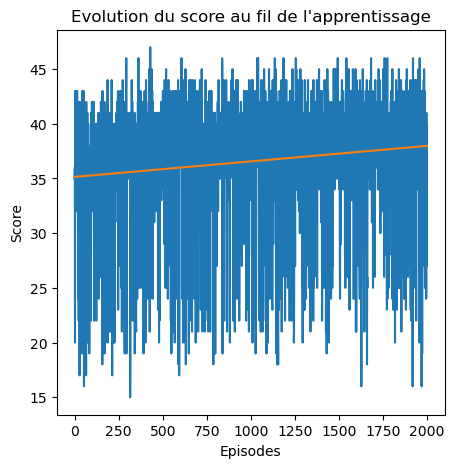

In [18]:
from figures import *
import matplotlib.pyplot as plt

class first_visit_MC():
    def choose_action(self, state, actions):
        best_action = (0, -1)
        vmax = -1
        for action, reward in actions:
            new_state = state.copy()
            new_state[action] = True
            new_state = tuple(new_state)
            v = reward + self.state_value[new_state]/self.state_count[new_state]
            if v > vmax:
                best_action = (action, reward)
                vmax = v
        return best_action
    
    def learn(self, n_episodes, game:YamsEnv, gamma=0.9):
        self.state_value = {state:10000 for state in game.states}
        self.state_count = {state:1 for state in game.states}
        self.game = game
        self.scores = []
        for _ in tqdm(range(n_episodes), desc='Learning'):
            self.game.reset()
            r_game, history = self.game.play_game()
            explored = {}
            tot_reward = 0
            for state, reward in history[::-1]:
                tot_reward = tot_reward * gamma + reward
                explored[state] = tot_reward
            for state, v in explored.items():
                self.state_value[state] += v
                self.state_count[state] += 1
            self.scores.append(r_game)
        for state in self.state_value:
            self.state_value[state] /= self.state_count[state]
        self.state_value[tuple([True]*len(self.game.figures))] = 0
        return self.scores
    
    def test(self, game:YamsEnv):
        self.game = game
        self.game.reset()
        r_game, _ = self.game.play_game()
        return r_game

rl = first_visit_MC()
env = YamsEnv(3, 3, [Multiple(3, 15), Multiple(2, 5), Number(0), Number(1), Number(2), Chance()], rl.choose_action)
scores = rl.learn(2000, env, gamma=1)
plt.figure(figsize=(5, 5))
plt.title("Evolution du score au fil de l'apprentissage")
plt.ylabel("Score")
plt.xlabel("Episodes")
plt.plot(scores)
plt.plot(np.polyval(np.polyfit(range(len(scores)), scores, 1), range(len(scores))))
plt.show()

### Test avec 3 dès à 3 faces

In [19]:
from yams_env import random_policy
from tqdm import tqdm

_ = rl.learn(20000, env, gamma=1.0)
best_scores = []
for i in tqdm(range(10000), desc='Test on best policy'):
    best_scores.append(rl.test(env))
print(f'Score moyen best policy: {np.mean(best_scores)}')

random_env = YamsEnv(3, 3, [Multiple(3, 15), Multiple(2, 5), Number(0), Number(1), Number(2), Chance()], random_policy)
random_scores = []
for i in tqdm(range(10000), desc='Test on random policy'):
    random_scores.append(rl.test(random_env))
print(f'Score moyen random policy: {np.mean(random_scores)}')

greedy_env = YamsEnv(3, 3, [Multiple(3, 15), Multiple(2, 5), Number(0), Number(1), Number(2), Chance()], default_RL_policy)
greedy_scores = []
for i in tqdm(range(10000), desc='Test on greedy policy'):
    greedy_scores.append(rl.test(greedy_env))
print(f'Score moyen greedy policy: {np.mean(greedy_scores)}')

Test on best policy: 100%|██████████| 10000/10000 [00:03<00:00, 2900.53it/s]


Score moyen best policy: 37.1723


Test on random policy: 100%|██████████| 10000/10000 [00:02<00:00, 3479.04it/s]


Score moyen random policy: 32.6382


Test on greedy policy: 100%|██████████| 10000/10000 [00:02<00:00, 3438.16it/s]

Score moyen greedy policy: 37.1425


### Test avec 5 dès à 6 faces

In [20]:
best_env = YamsEnv(5, 6, [Number(0), Number(1), Number(2), Number(3), Number(4), Number(5), Brelan(), Multiple(4, 30), Multiple(5, 50), Chance()], rl.choose_action, 'turnQsF.npy')
best_scores = []
_ = rl.learn(20000, best_env, gamma=1.0)
for i in tqdm(range(10000), desc='Test on best policy'):
    best_scores.append(rl.test(best_env))
print(f'Score moyen best policy: {np.mean(best_scores)}')

random_env = YamsEnv(5, 6, [Number(0), Number(1), Number(2), Number(3), Number(4), Number(5), Brelan(), Multiple(4, 30), Multiple(5, 50), Chance()], random_policy, 'turnQsF.npy')
random_scores = []
for i in tqdm(range(10000), desc='Test on random policy'):
    random_scores.append(rl.test(random_env))
print(f'Score moyen random policy: {np.mean(random_scores)}')
    
greedy_policy = YamsEnv(5, 6, [Number(0), Number(1), Number(2), Number(3), Number(4), Number(5), Brelan(), Multiple(4, 30), Multiple(5, 50), Chance()], saved_turnQs='turnQsF.npy')
greedy_scores = []
for i in tqdm(range(10000), desc='Test on greedy policy'):
    greedy_scores.append(rl.test(greedy_policy))
print(f'Score moyen greedy policy: {np.mean(greedy_scores)}')

Test on best policy: 100%|██████████| 10000/10000 [00:12<00:00, 831.17it/s]


Score moyen best policy: 107.2309


Test on random policy: 100%|██████████| 10000/10000 [00:11<00:00, 858.31it/s]


Score moyen random policy: 87.9484


Test on greedy policy: 100%|██████████| 10000/10000 [00:11<00:00, 869.27it/s]

Score moyen greedy policy: 105.2133


- Ajouter algo (MC control(epsilon-greedy), SARSA ou Q-Learning)
- Visualisation value policy(Regarder value des états suivants)
- Explicabilité stratégie obtenue
- Comparer avec environnement $state = (scored\_figures, tot\_reward)$

